# Install and load packages as necessary

In [46]:
# Package names
packages<-c("dplyr", "lubridate", "ggplot2", "ggpubr")

# Install packages if necessary
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Load packages
invisible(lapply(packages, library, character.only = TRUE))

## Function to create a new directory if it does not exist

In [47]:
# check if directory exists, create if not
newDir<-function(dirPath){
  if(dir.exists(dirPath)){
    cat(sprintf("Output directory, %s, already exists\n", dirPath))
  }
  else{
    cat(sprintf("Output directory not found, creating: %s\n",dirPath))
    dir.create(dirPath)
  }
}

# Generate output directory name and directory

In [48]:
outputDirectory <- paste(getwd(),"/Methane_Calibration/",sep="")
outputDirectory
newDir(outputDirectory)

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/methane_tests/Methane_Calibration/"

Output directory, /home/pleocavee/Documents/github/SensorDataProcessing/methane_tests/Methane_Calibration/, already exists


# Locate calibration directories MANUAL ENTRY

In [49]:
# HARDCODED directory that contains all the calibration folders
# each calibration folder must contain a file called "calibration_data.csv"
# which is a subset of data points from each calibration run to use
dataDirectory<-"~/Desktop/data/mesoBinTests/"

# Function that concatenates all the calibration_data.csv

In [50]:
concat_calibration<-function(directory=dataDirectory){
    #define custom call to read.csv and remove debug lines & where logger is not populated
    readCSV<-function(filePath){
        fileData<-read.csv(filePath,header=TRUE)
        fileData<-subset(fileData, type!="debug" & !is.na(logger))
    }
    
    # find directories with the word calibration
    calDirs<-list.files(path=directory, recursive=FALSE, pattern="*calibration*", full.names=TRUE)
    
    # affix the correct file name to each folder found
    calFiles<-paste(calDirs,"/calibration_data.csv",sep="")
    
    # check that all those files exist
    if ( all( file.exists(calFiles) ) == FALSE ){
        print("Error: calibration directory missing calibration_data.csv")
        return(NULL)
    } else {
        print(sprintf("%i calibration files found",length(calFiles))) #include number of files found, sprintf?
    }
    
    #read each file and output a single dataframe
    data<-do.call(rbind, lapply(calFiles,readCSV))
    return(data)
}

In [51]:
calData<-concat_calibration()
# str(calData)

[1] "5 calibration files found"


# Function to process column types

In [52]:
process_columns<-function(df){
    df$type<-as.factor(df$type)
    df$site<-as.factor(df$site)
    df$logger<-as.factor(df$logger)
    df$deployment<-as.factor(df$deployment)
    df$deployed_at<-as.integer(df$deployed_at)
    df$uuid<-as.factor(df$uuid)
    df$time.s<-as.numeric(df$time.s)
    df$time.h<-lubridate::as_datetime(df$time.h)
    
    cols<-names(df)
    if("measurementCycle" %in% cols & "burstCycle" %in% cols){
        df$measurementCycle<-as.numeric(df$measurementCycle)
        df$burstCycle<-as.factor(df$burstCycle)
    }
    
    ##hardcoded, but could be all columns between time.h and user_note? or measurementCycle when included
    df$battery.V<-as.numeric(df$battery.V)
    df$dht_C<-as.numeric(df$dht_C)
    df$dht_RH<-as.numeric(df$dht_RH)
    
    if("atlas_CO2_ppm" %in% cols){
        df$atlas_CO2_ppm<-as.numeric(df$atlas_CO2_ppm)
    }
    
    df$ch4rf_raw<-as.numeric(df$ch4rf_raw)
    df$ch4rf_cal<-as.numeric(df$ch4rf_cal)
    df$ch4_raw<-as.numeric(df$ch4_raw)
    df$ch4_cal<-as.numeric(df$ch4_cal)
    
    return(df)
}

In [53]:
calData<-process_columns(calData)
str(calData)

'data.frame':	150 obs. of  21 variables:
 $ X               : int  23262 24012 24762 25512 26262 218374 218449 218524 218599 218674 ...
 $ type            : Factor w/ 1 level "summary": 1 1 1 1 1 1 1 1 1 1 ...
 $ site            : Factor w/ 6 levels "C1","C2","C3",..: 1 1 1 1 1 2 2 2 2 2 ...
 $ logger          : Factor w/ 6 levels "21001","21010",..: 2 2 2 2 2 3 3 3 3 3 ...
 $ deployment      : Factor w/ 6 levels "floatWaterBin-50FF6C068678545210222467-1675179416",..: 5 5 5 5 5 3 3 3 3 3 ...
 $ deployed_at     : int  1675266374 1675266374 1675266374 1675266374 1675266374 1675179576 1675179576 1675179576 1675179576 1675179576 ...
 $ uuid            : Factor w/ 6 levels "50FF6C068678545210222467",..: 5 5 5 5 5 3 3 3 3 3 ...
 $ time.s          : num  1.68e+09 1.68e+09 1.68e+09 1.68e+09 1.68e+09 ...
 $ time.h          : POSIXct, format: "2023-02-02 16:30:27" "2023-02-02 16:31:27" ...
 $ battery.V       : num  1343 1347 1347 1351 1350 ...
 $ measurementCycle: num  9 9 9 9 9 ...
 $ burstCycl

# Function to average data for each sensor/site and measurement cycle

In [54]:
names(calData)

[1] "X"                "type"             "site"             "logger"          
 [5] "deployment"       "deployed_at"      "uuid"             "time.s"          
 [9] "time.h"           "battery.V"        "measurementCycle" "burstCycle"      
[13] "dht_C"            "dht_RH"           "ch4rf_raw"        "ch4rf_cal"       
[17] "ch4_raw"          "ch4_cal"          "user_note"        "user_value"      
[21] "ch4_ppm"

In [55]:
average_runs<-function(df){
    grouped <- group_by(df, site, measurementCycle)
    means <- summarise(grouped,
                       type=type,
                       site=site,
                       deployment=deployment,
                       deployed_at=deployed_at,
                       uuid=uuid,
                       time.s=mean(time.s),
                       time.h=mean(time.h),
                       battery.V=mean(battery.V),
                       ch4rf_raw=mean(ch4rf_raw),
                       ch4rf_cal=mean(ch4rf_cal),
                       ch4_raw=mean(ch4_raw),
                       ch4_cal=mean(ch4_cal),
                       dht_C=mean(dht_C),
                       dht_RH=mean(dht_RH),
                       ch4_ppm=mean(ch4_ppm)
                      )
    return(means)
}

In [56]:
calMeans<-average_runs(calData)
calMeans

`summarise()` has grouped output by 'site', 'measurementCycle'. You can override using the `.groups` argument.



site,measurementCycle,type,deployment,deployed_at,uuid,time.s,time.h,battery.V,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,dht_C,dht_RH,ch4_ppm
<fct>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,0,1507.78,0,31.18,20.78,1.995856
C1,2344,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1676064747,2023-02-10 21:32:27,1332.2,2004.66,0,1476.56,0,26.90,19.30,1.993235
C1,2344,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1676064747,2023-02-10 21:32:27,1332.2,2004.66,0,1476.56,0,26.90,19.30,1.993235
C1,2344,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1676064747,2023-02-10 21:32:27,1332.2,2004.66,0,1476.56,0,26.90,19.30,1.993235
C1,2344,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1676064747,2023-02-10 21:32:27,1332.2,2004.66,0,1476.56,0,26.90,19.30,1.993235


# some basic hardcoded plots

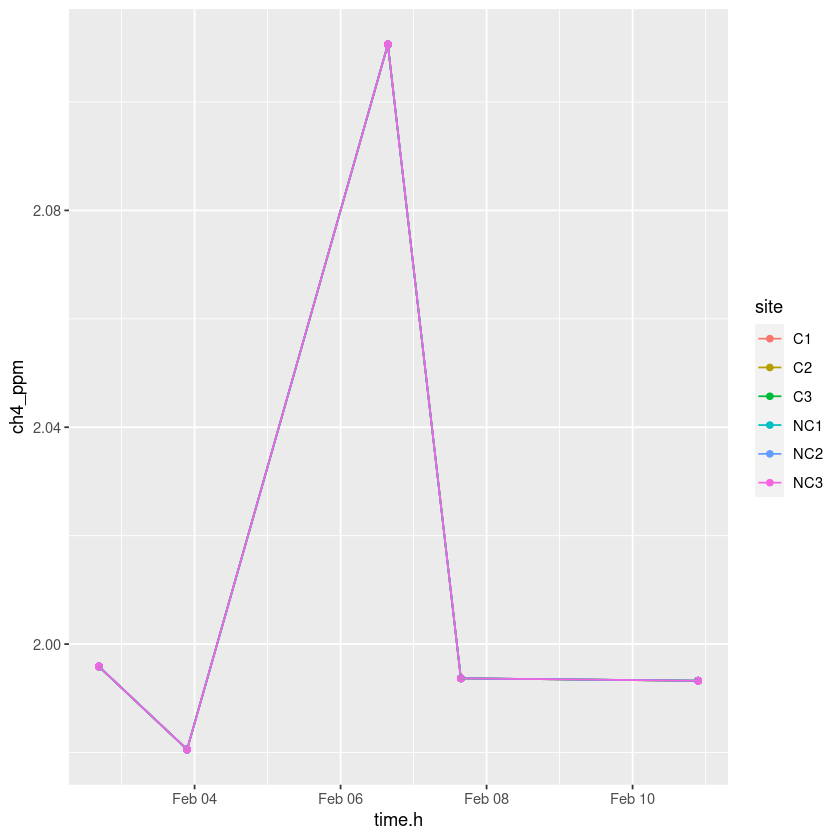

In [57]:
# gas analyzer
ggplot(calMeans,aes(x=time.h,y=ch4_ppm,color=site))+geom_point()+geom_line()

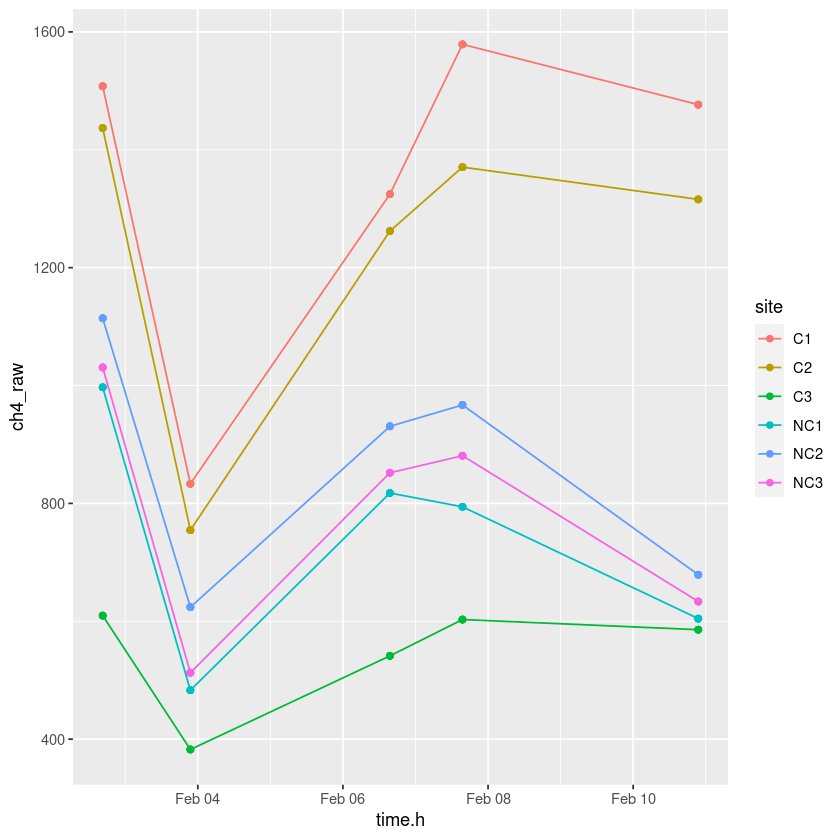

In [58]:
ggplot(calMeans,aes(x=time.h,y=ch4_raw,color=site))+geom_point()+geom_line()

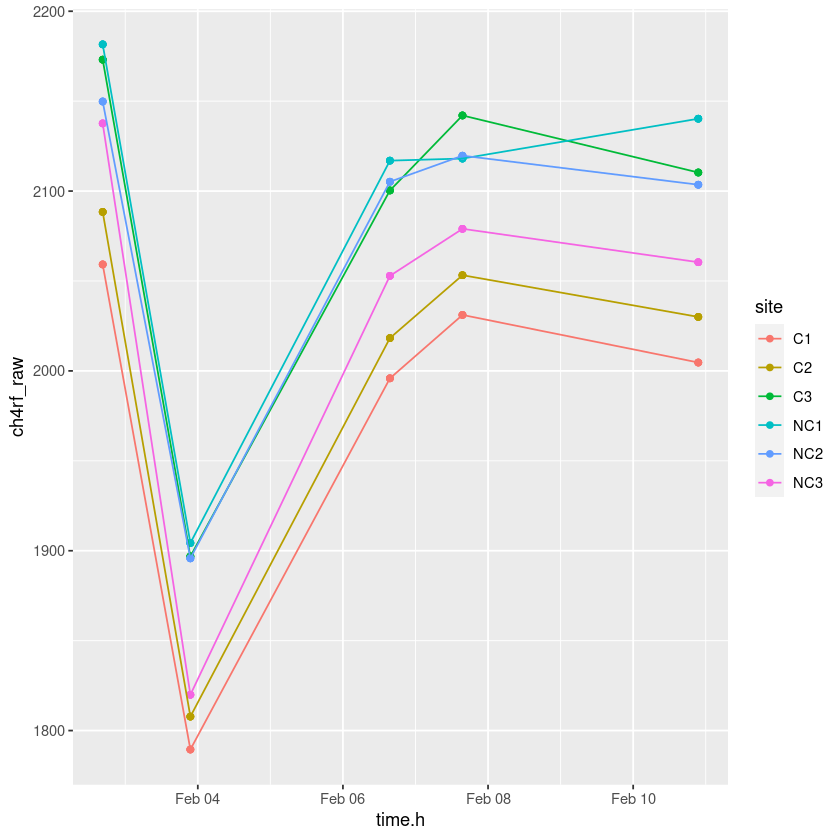

In [59]:
ggplot(calMeans,aes(x=time.h,y=ch4rf_raw,color=site))+geom_point()+geom_line()

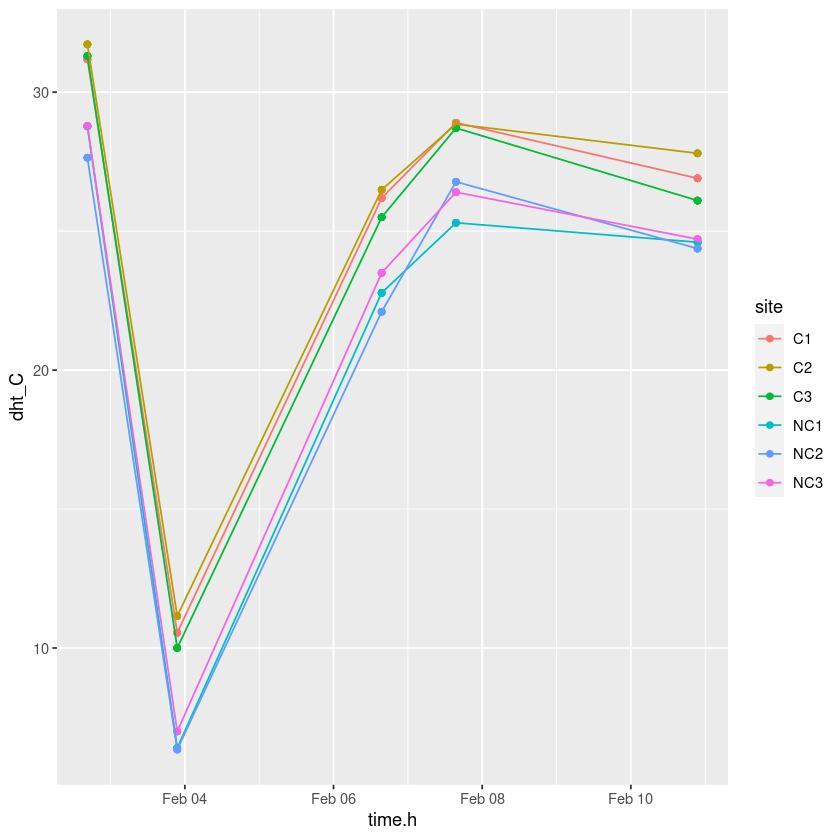

In [60]:
ggplot(calMeans,aes(x=time.h,y=dht_C,color=site))+geom_point()+geom_line()

`geom_smooth()` using formula 'y ~ x'



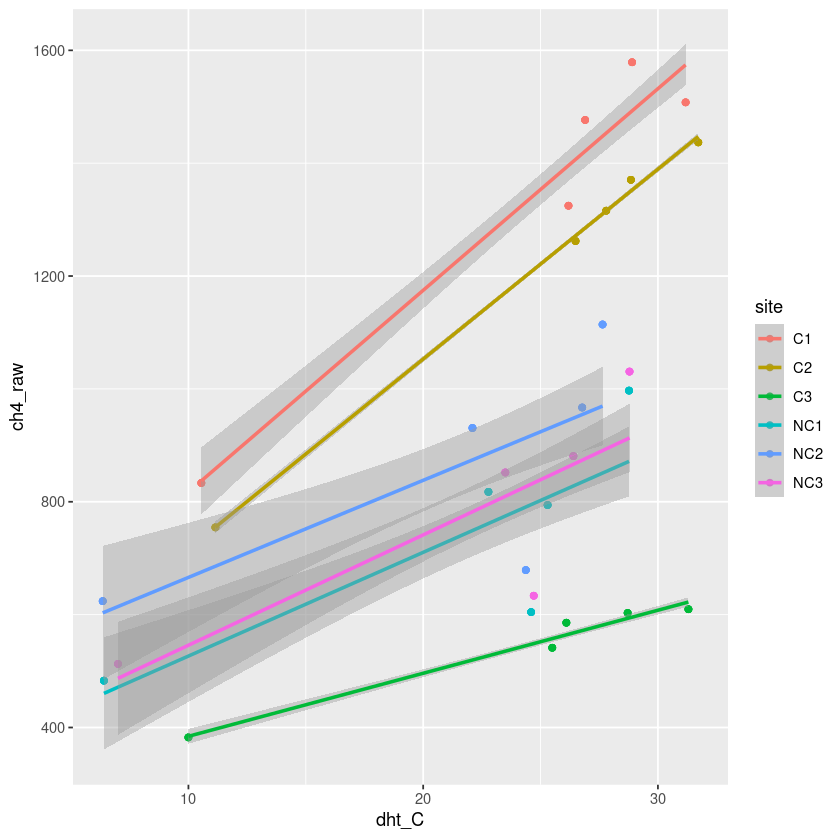

In [61]:
# ch4 vs C
ggplot(calMeans,aes(x=dht_C,y=ch4_raw,color=site))+geom_point()+geom_smooth(method="lm")

`geom_smooth()` using formula 'y ~ x'



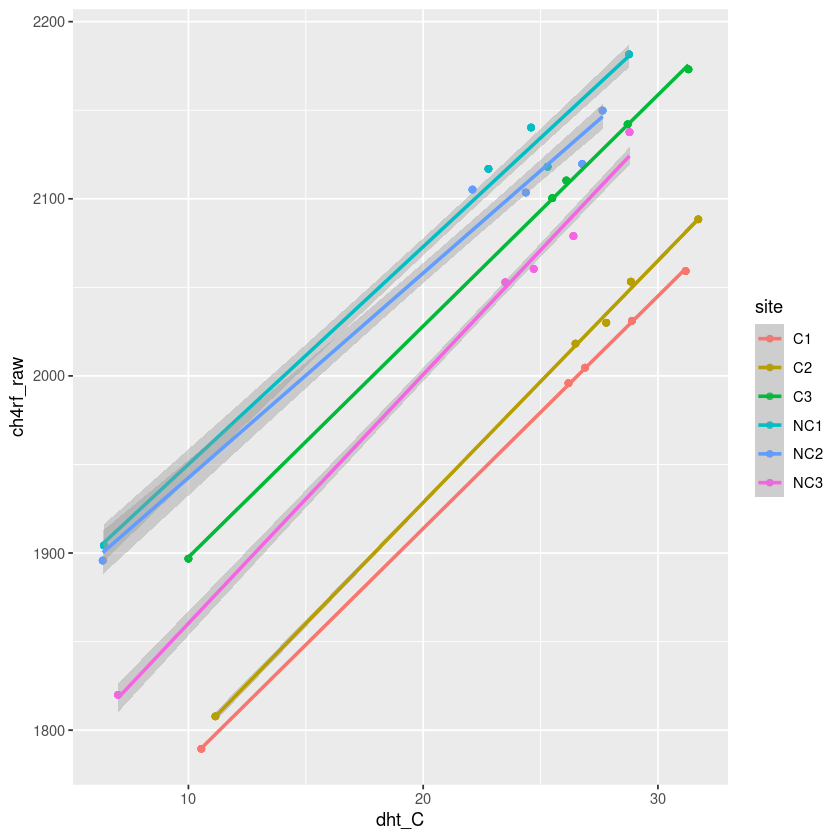

In [62]:
# reference vs C
ggplot(calMeans,aes(x=dht_C,y=ch4rf_raw,color=site))+geom_point()+geom_smooth(method="lm")

`geom_smooth()` using formula 'y ~ x'



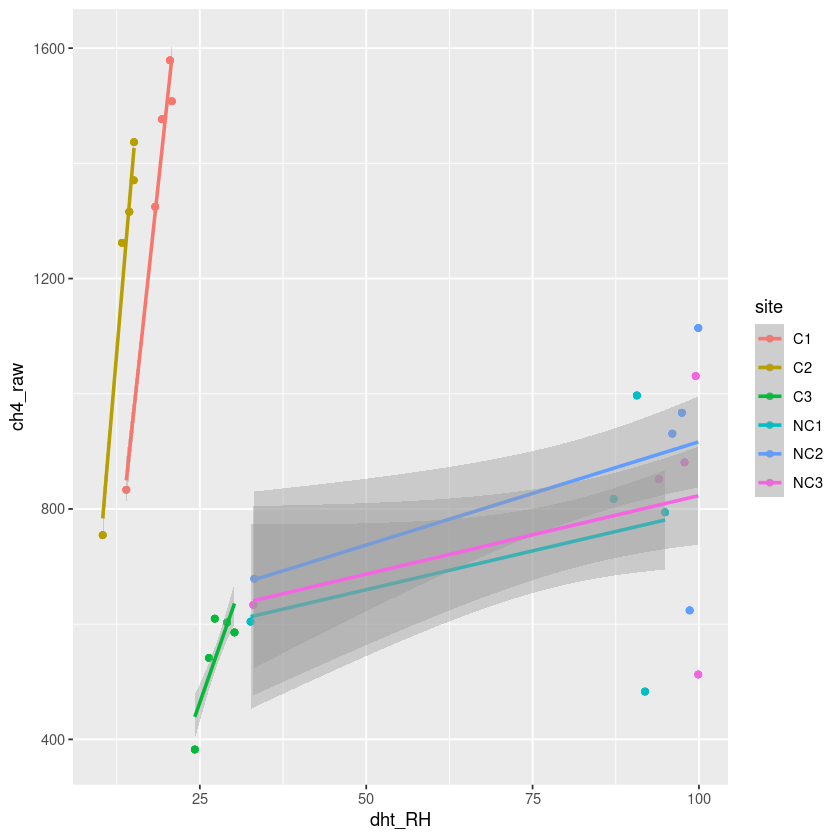

In [63]:
# ch4 vs RH
ggplot(calMeans,aes(x=dht_RH,y=ch4_raw,color=site))+geom_point()+geom_smooth(method="lm")

`geom_smooth()` using formula 'y ~ x'



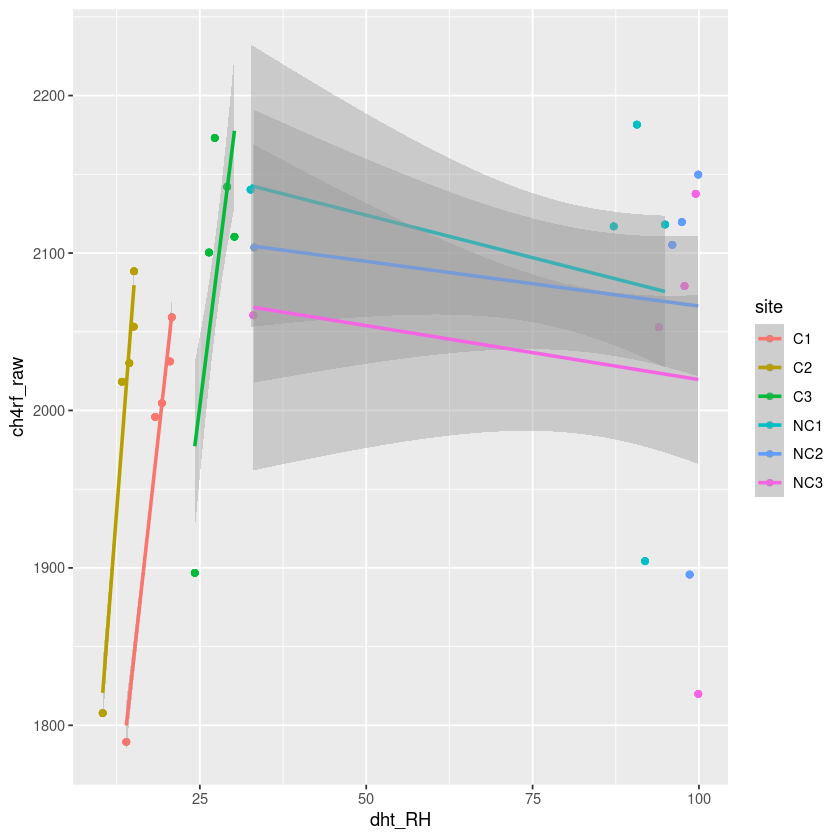

In [64]:
# reference vs RH
ggplot(calMeans,aes(x=dht_RH,y=ch4rf_raw,color=site))+geom_point()+geom_smooth(method="lm")

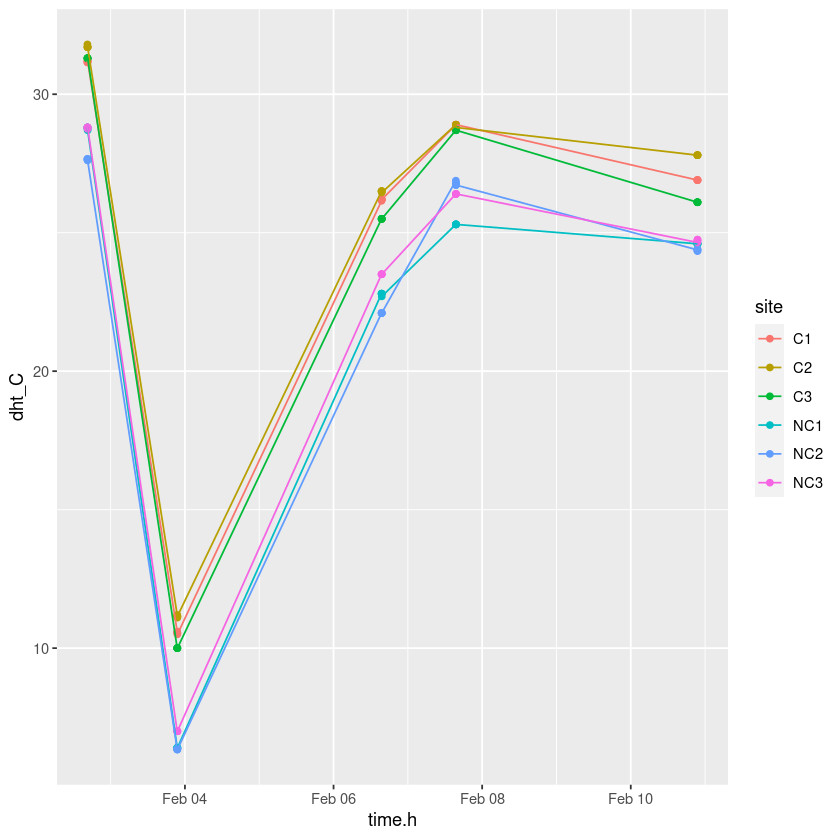

In [65]:
ggplot(calData,aes(x=time.h,y=dht_C,color=site))+geom_point()+geom_line()

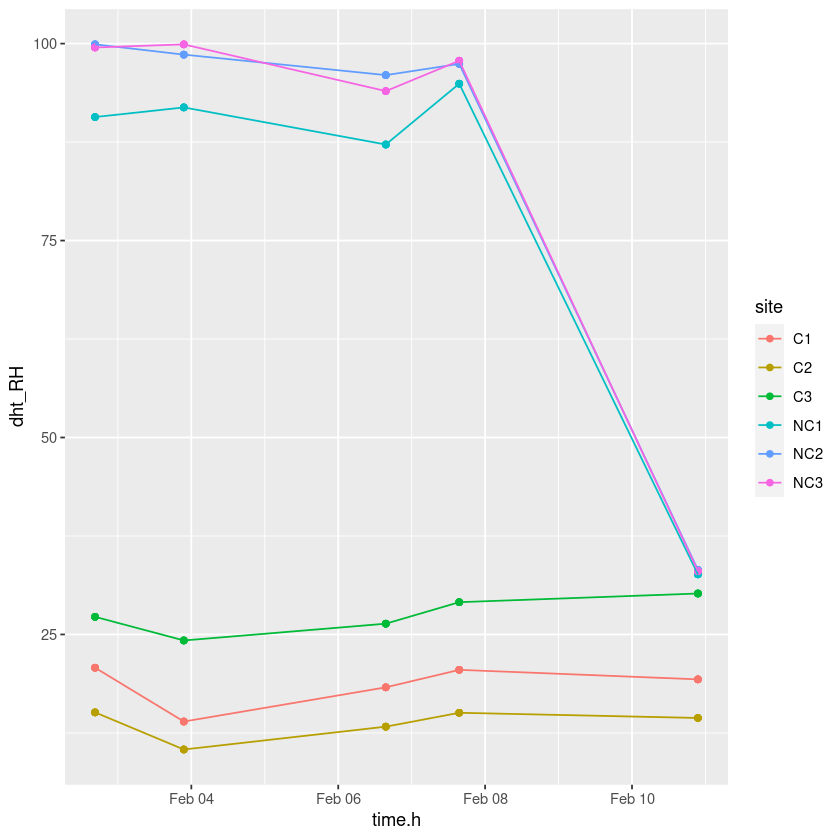

In [66]:
ggplot(calMeans,aes(x=time.h,y=dht_RH,color=site))+geom_point()+geom_line()

In [67]:
encasedData<-calMeans[calMeans$site==c("C1","C2","C3"),]
noCaseData<-calMeans[calMeans$site==c("NC1","NC2","NC3"),]

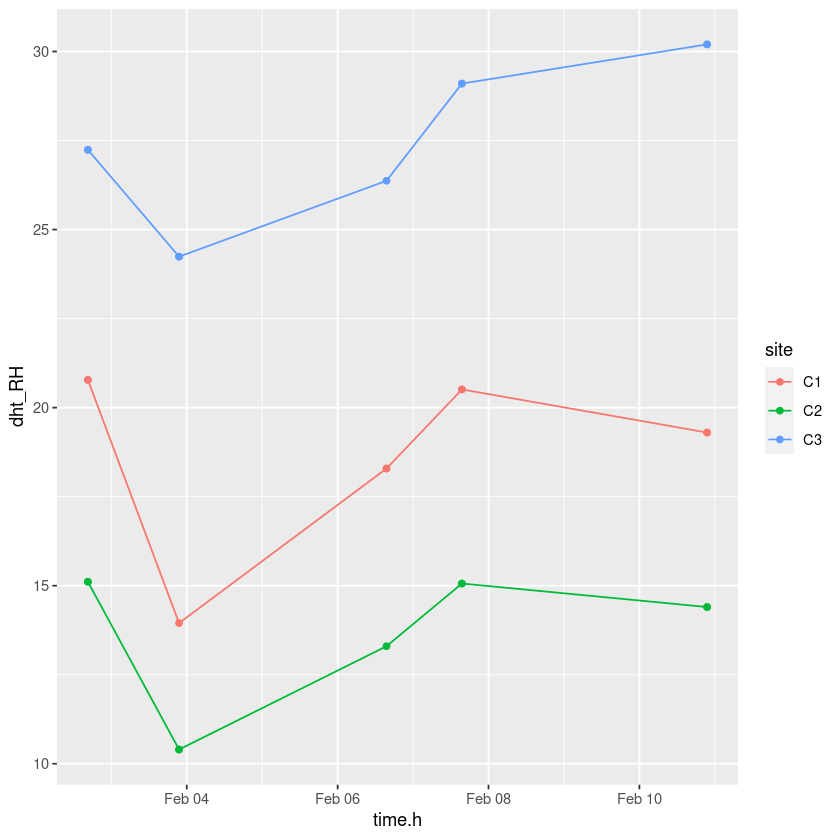

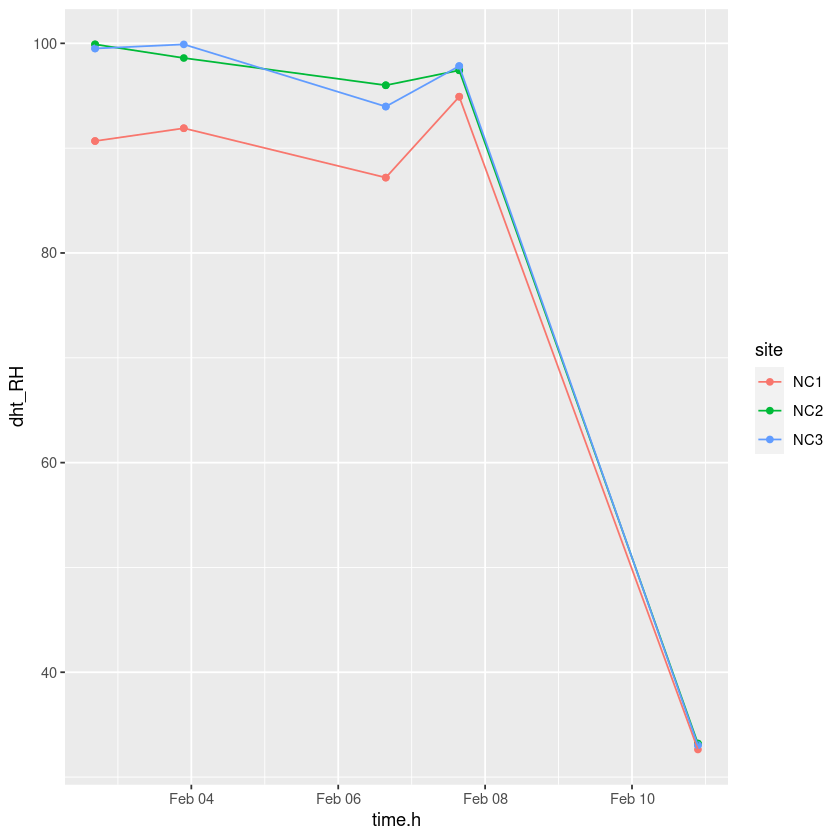

In [68]:
a<-ggplot(encasedData,aes(x=time.h,y=dht_RH,color=site))+geom_point()+geom_line()
b<-ggplot(noCaseData,aes(x=time.h,y=dht_RH,color=site))+geom_point()+geom_line()
a
b
# ggarrange(a,b)

# math

In [24]:
df<-calMeans
df$dht_K<-df$dht_C+273.15

#determine water vapor saturation point (https://www.orslabs.fr/pdf/Humidity%20Equations.pdf)
P<-1013.25 #millibar, standard pressure ~1 atmosphere
df$ews_mbar<-(1.0007+3.46*10^-6*P)*6.1121^(17.502*df$dht_C/(240.9+df$dht_C))
df$ews_kPa<-df$ews_mbar/10

#convert relative humidity to molar PPM (https://www.learnthermo.com/examples/ch02/p-2d-9.php)
# note: assuming 1 atmosphere, 101.325 kPa, and volume of 1
df$H2O_mol<-df$dht_RH*df$ews_kPa/101.325
df$BDA_mol<-1-df$H2O_mol #mass of dry air

MW_H2O<-18.01528
MW_BDA<-28.97

df$MW_gas<-df$BDA_mol*MW_BDA+df$H2O_mol*MW_H2O


#vaisala absolute humidity equation (https://www.hatchability.com/Vaisala.pdf)
C<-2.16679 #gK/J
# df$aH_gm3<-C*df$PH2O_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)
df$aH_gm3<-C*df$ews_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)

head(df)

site,measurementCycle,type,deployment,deployed_at,uuid,time.s,time.h,battery.V,ch4rf_raw,⋯,dht_C,dht_RH,ch4_ppm,dht_K,ews_mbar,ews_kPa,H2O_mol,BDA_mol,MW_gas,aH_gm3
<fct>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.90437,3.790437,0.7773529,0.2226471,20.45432,5.607985
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.90437,3.790437,0.7773529,0.2226471,20.45432,5.607985
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.90437,3.790437,0.7773529,0.2226471,20.45432,5.607985
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.90437,3.790437,0.7773529,0.2226471,20.45432,5.607985
C1,9,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675355547,2023-02-02 16:32:27,1347.6,2059.20,⋯,31.18,20.78,1.995856,304.33,37.90437,3.790437,0.7773529,0.2226471,20.45432,5.607985
C1,2315,summary,floatWaterBin-57FF70068387575129270167-1675266374,1675266374,57FF70068387575129270167,1675960347,2023-02-09 16:32:27,1321.8,1990.44,⋯,25.78,18.80,2.023783,298.93,21.47806,2.147806,0.3985073,0.6014927,24.60446,2.926849


`geom_smooth()` using formula 'y ~ x'



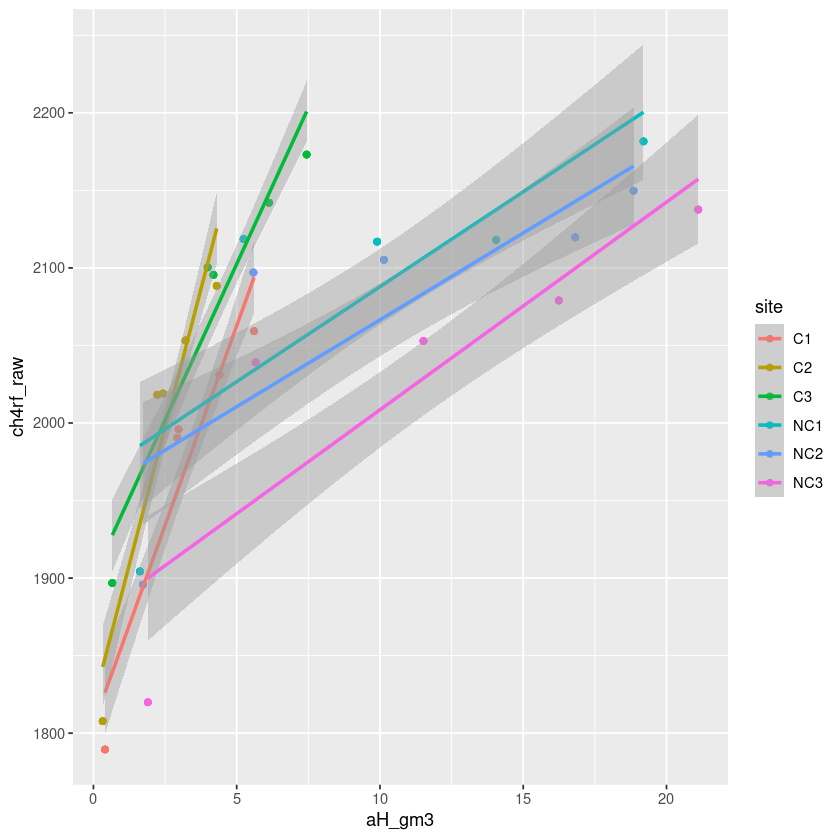

In [25]:
# reference vs RH
ggplot(df,aes(x=aH_gm3,y=ch4rf_raw,color=site))+geom_point()+geom_smooth(method="lm")

`geom_smooth()` using formula 'y ~ x'



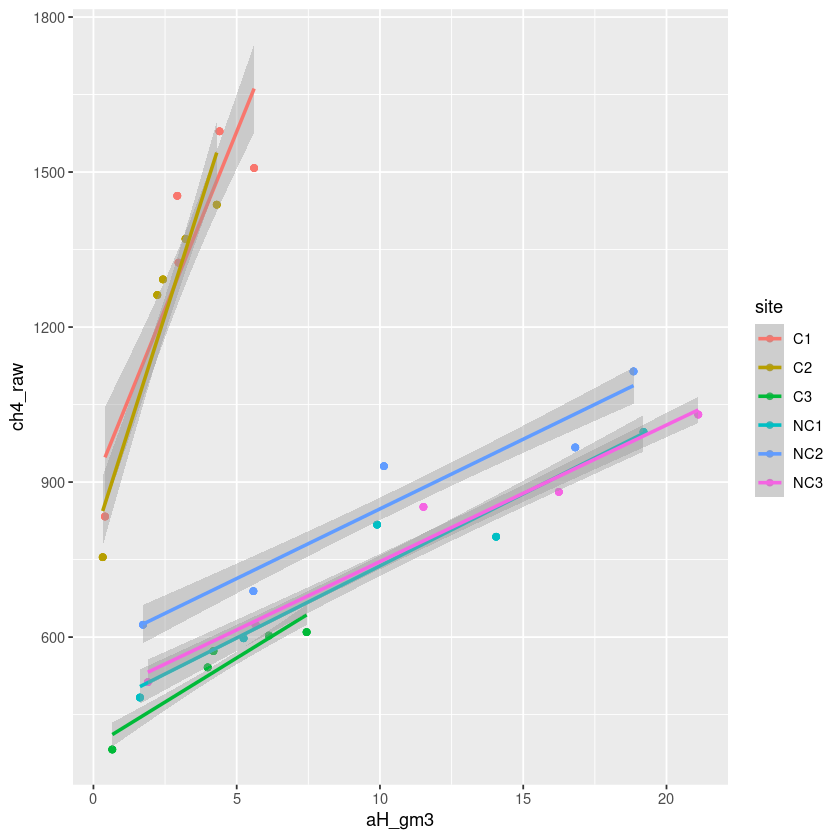

In [26]:
# reference vs RH
ggplot(df,aes(x=aH_gm3,y=ch4_raw,color=site))+geom_point()+geom_smooth(method="lm")

`geom_smooth()` using formula 'y ~ x'



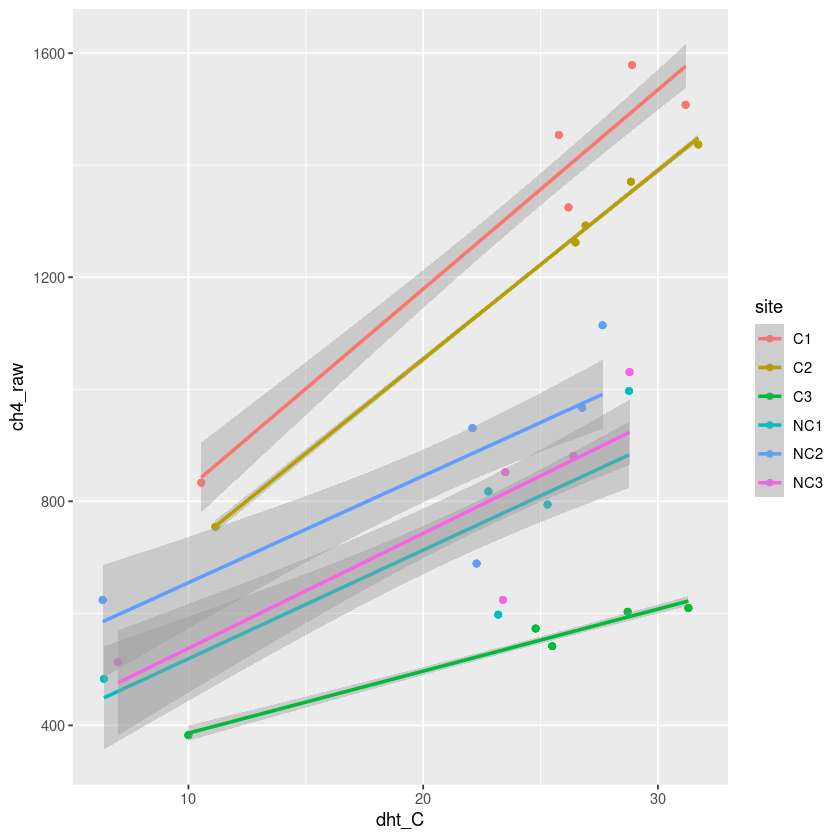

In [27]:
# raw vs temperature
ggplot(df,aes(x=dht_C,y=ch4_raw,color=site))+geom_point()+geom_smooth(method="lm")

`geom_smooth()` using formula 'y ~ x'



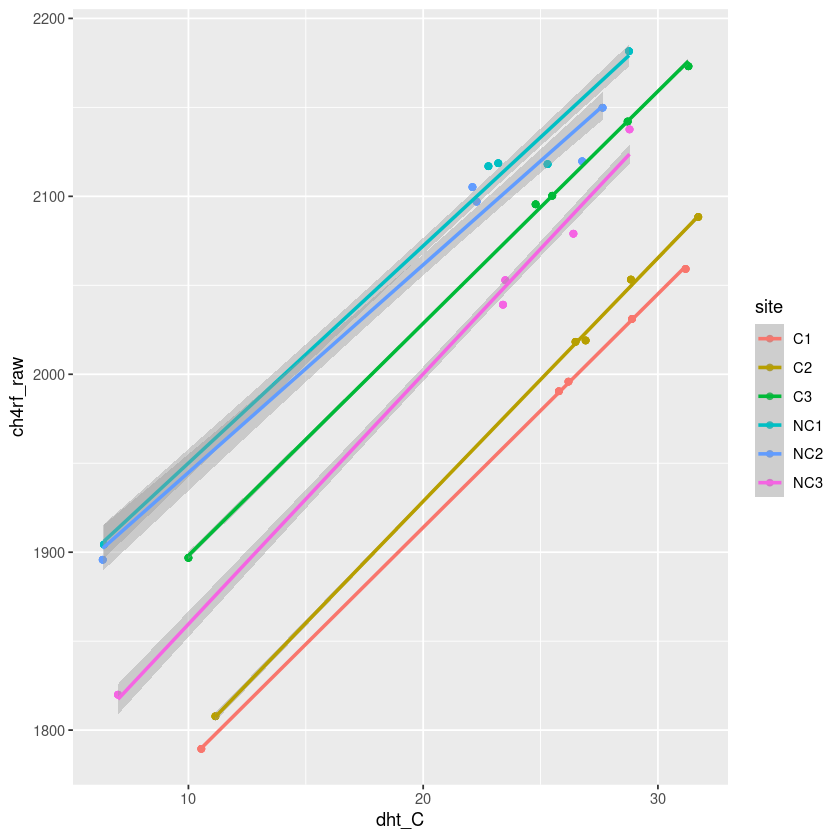

In [28]:
# reference vs temperature
ggplot(df,aes(x=dht_C,y=ch4rf_raw,color=site))+geom_point()+geom_smooth(method="lm")

`geom_smooth()` using formula 'y ~ x'



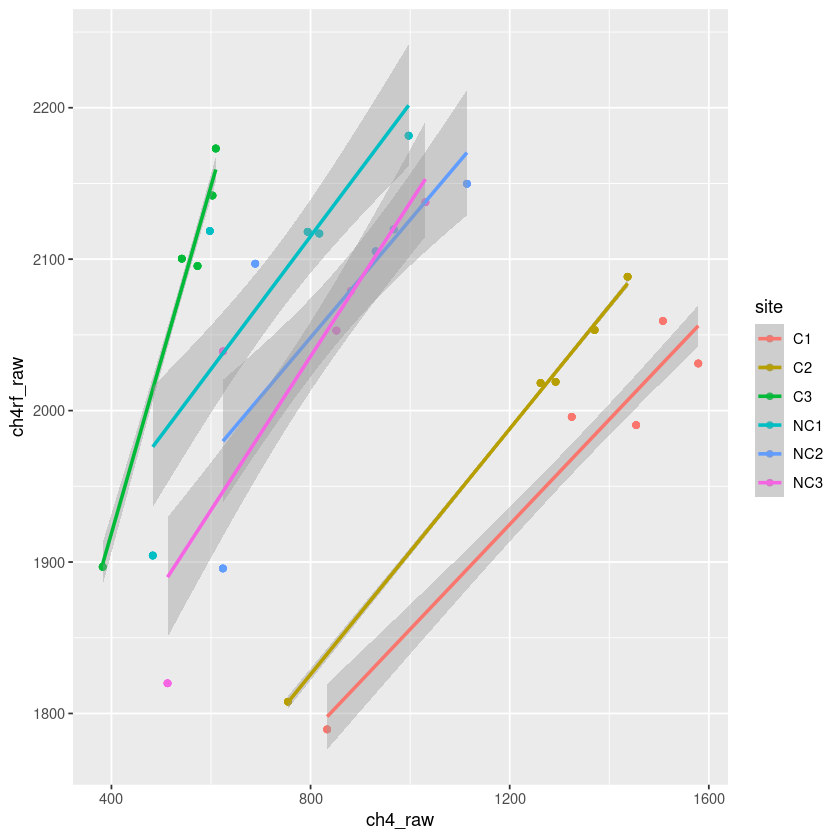

In [29]:
# reference vs temperature
ggplot(df,aes(x=ch4_raw,y=ch4rf_raw,color=site))+geom_point()+geom_smooth(method="lm")

# LAB TODO

In [30]:
# TODO: nalgene bottles with sensor w/cable gland in it to test for volume, water -> graduated cylinder
# highest methane concentration to test will be 1mL CH4 gas / 1000mL air
# 1000 ppm, based on adding gas into air volume

# testing 10, 100, 150, 1000 ppm for calibration

# Function to write lines to a complete file path

todo, check if file exists and append? default overwrites

In [31]:
writeFile<-function(lines, filePath){
    fd<-file(filePath)
    writeLines(lines, fd)
    close(fd)
}

# V0 modeling

In [32]:
# HARDCODED sensor names need to be incorporated at some point, right now sensors aren't named in code settings
# site name = sensor name
CH4dict <- c(
    "C1"="CH001",
    "C2"="CH002",
    "C3"="CH003",
    "NC1"="CH004",
    "NC2"="CH005",
    "NC3"="CH006"
)

In [33]:
#HARDCODED models to run and names for them
lm_models <- c(
    "additive"="ch4_raw~dht_C+aH_gm3",
    "interactive"="ch4_raw~dht_C*aH_gm3"
)

In [34]:
# input is dataframe, id column, and dictionary pairing a column of unique identifiers to sensor names
# output structure is list of sensors, with list of models
V0_lm_list<-function(dataframe, idCol, sensorNames, models, outputDir=outputDirectory){
    #ids to be paired in sensorNames
    ids <- unique( df[[idCol]] )
    
    #initialize output list based on sensorNames
    output <- vector( "list", length(ids))
    names(output) <- sensorNames

    model_L<-length(models)
    #initialize each sensor in output to have a spot for each model
    for(sensor in sensorNames){
        output[[sensor]]<-vector("list", model_L)
        names(output[[sensor]])<-names(models)
    }
    
    # can add a check to evaluate adj r sq between each model
    # run models for each sensor, save models to list, save summaries of models to individual text files
    for(id in ids){
        sensor<-sensorNames[id]
        subset<-dataframe[ dataframe[[idCol]] == id ,]        
        for(i in 1:length(models)){
            outFile<-paste(outputDirectory, sensor,"_V0_", names(models[i]),"_lm.txt", sep="")
            temp_lm<-lm(models[i], data=subset)
            temp_lm$call[[2]]<-as.formula(models[i]) #edit lm() call so that it doesn't save as "models[i]"
            output[[sensor]][[names(models[i])]]<-temp_lm # store the lm
            
            # save summary of lm to text file
                # note additional info lines can be added with c()
            writeLines<-capture.output(summary( output[[sensor]][[names(models[i])]]))
            writeFile(writeLines, outFile)
        }
    }
    #save output to .rds
    outFile<-paste(outputDirectory,"V0_lm_",sensorNames[1],"-",sensorNames[length(sensorNames)],".rds",sep="")
    saveRDS(output, outFile)
    return(output) # list of list, or return the name of the file generated and saved?
}
V0_models<-V0_lm_list(df, 'site', CH4dict, lm_models)
V0_models

$CH001
$CH001$additive

Call:
lm(formula = ch4_raw ~ dht_C + aH_gm3, data = subset)

Coefficients:
(Intercept)        dht_C       aH_gm3  
     409.31        41.31       -25.28  


$CH001$interactive

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
      886.45        -62.25       2028.47        -50.46  



$CH002
$CH002$additive

Call:
lm(formula = ch4_raw ~ dht_C + aH_gm3, data = subset)

Coefficients:
(Intercept)        dht_C       aH_gm3  
    372.906       34.368       -3.894  


$CH002$interactive

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
     446.080        19.860       369.950        -9.021  



$CH003
$CH003$additive

Call:
lm(formula = ch4_raw ~ dht_C + aH_gm3, data = subset)

Coefficients:
(Intercept)        dht_C       aH_gm3  
    267.959       11.898       -2.765  


$CH003$interactive

Call:
lm(form

# Read V0 models from RData file

In [35]:
V0_file<-"~/Documents/github/SensorDataProcessing/methane_tests/Methane_Calibration/V0_lm_CH001-CH006.rds"
V0_models_read<-readRDS(V0_file)

# Testing predict() on output from function and read off of RData file

In [36]:
CH4_dict_L<-length(CH4dict)
for(i in 1:CH4_dict_L){
    # script generated
    print(predict(V0_models[[CH4dict[i]]][["interactive"]], newdata=df[df$site==names(CH4dict[i]),]))
    # read from file
    print(predict(V0_models_read[[CH4dict[i]]][["interactive"]], newdata=df[df$site==names(CH4dict[i]),]))
    break
}

        1         2         3         4         5         6         7         8 
1498.6373 1498.6373 1498.6373 1498.6373 1498.6373 1411.6494 1411.6494 1411.6494 
        9        10        11        12        13        14        15        16 
1411.6494 1411.6494  834.6115  834.6115  834.6115  834.6115  834.6115 1356.9839 
       17        18        19        20        21        22        23        24 
1356.9839 1356.9839 1356.9839 1356.9839 1596.7179 1596.7179 1596.7179 1596.7179 
       25 
1596.7179 
        1         2         3         4         5         6         7         8 
1498.6373 1498.6373 1498.6373 1498.6373 1498.6373 1411.6494 1411.6494 1411.6494 
        9        10        11        12        13        14        15        16 
1411.6494 1411.6494  834.6115  834.6115  834.6115  834.6115  834.6115 1356.9839 
       17        18        19        20        21        22        23        24 
1356.9839 1356.9839 1356.9839 1356.9839 1596.7179 1596.7179 1596.7179 1596.7179 
      

# Self predict

In [45]:
CH4_dict_L<-length(CH4dict)
for(i in 1:CH4_dict_L){
    print(CH4dict[i])
    print(predict(V0_models_read[[CH4dict[i]]][["interactive"]], newdata=df[df$site==names(CH4dict[i]),]))
}

     C1 
"CH001" 
        1         2         3         4         5         6         7         8 
1498.6373 1498.6373 1498.6373 1498.6373 1498.6373 1411.6494 1411.6494 1411.6494 
        9        10        11        12        13        14        15        16 
1411.6494 1411.6494  834.6115  834.6115  834.6115  834.6115  834.6115 1356.9839 
       17        18        19        20        21        22        23        24 
1356.9839 1356.9839 1356.9839 1356.9839 1596.7179 1596.7179 1596.7179 1596.7179 
       25 
1596.7179 
     C2 
"CH002" 
        1         2         3         4         5         6         7         8 
 754.6071  754.6071  754.6071  754.6071  754.6071 1289.3218 1289.3218 1289.3218 
        9        10        11        12        13        14        15        16 
1289.3218 1289.3218 1436.6323 1436.6323 1436.6323 1436.6323 1436.6323 1264.0997 
       17        18        19        20        21        22        23        24 
1264.0997 1264.0997 1264.0997 1264.0997 1371.6191 1

# test code

In [37]:
# # model for predicting V0 under varying temperature and humidity conditions

# #TODO function that runs through this for each sensor, then aggregates the data?

# # for each sensor, not all together
# c1_subset<-df[df$site=='C1',]

# a<-lm(ch4_raw~dht_C+aH_gm3,data=c1_subset) # + for additive

# b<-lm(ch4_raw~dht_C*aH_gm3,data=c1_subset) # * for interaction

# summary(a)

# summary(b)
# # choose based on R-squared, but will probably just always include the interaction effect since we know it's there

# # list of model objects to named sensors, then save rds
# # list("CH001"=b,"CH002"=c, etc)

In [38]:
# c1_subset<-df[df$site=='C1',]

# a<-lm(ch4_raw~dht_C+aH_gm3,data=c1_subset) # + for additive
# a

# lm_a_formula<-"ch4_raw~dht_C+aH_gm3"
# b<-lm(lm_a_formula, data=c1_subset)
# b

In [39]:
# a$call
# b$call
# b$call[[1]]
# b$call[[2]]
# b$call[[3]]

# b$call[[2]]<-as.formula(lm_a_formula)
# b$call

In [40]:
# c3_subset<-df[df$site=='C3',]

# c3_a<-lm(ch4_raw~dht_C+aH_gm3,data=c3_subset) # + for additive

# c3_b<-lm(ch4_raw~dht_C*aH_gm3,data=c3_subset) # * for interaction

# summary(c3_a)

# summary(c3_b)

In [41]:
# test<-summary(c3_a)
# class(test)
# # str(test)

# test$adj.r.squared

In [42]:
# # predict, column names in newdata must match those used in the linear model
# # predicting V0 for each point provided in data
# # each sensor has its own model
# predict(b, newdata=c1_subset)

In [43]:
# support vector machine - machine learning to fit values to an equation in the bastviken paper Table 2